In [1]:
%matplotlib inline

import os
# running with non gpu singularity container, so commented out the next line to use CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
tf.set_random_seed(42)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print "import tensorflow"
           
import keras.backend.tensorflow_backend as K

import keras
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, Lambda
from keras.layers import Input, merge, Concatenate, concatenate, Add, Multiply
from keras.losses import binary_crossentropy
from keras.optimizers import RMSprop,Adadelta
print "import keras"

import numpy as np
# from tqdm import tqdm
import time
import pickle
import sys
import glob
import hashlib
import math

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

print "import matplotlib"

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import binned_statistic_2d
from scipy.stats import ks_2samp


print "import sklearn"

np.random.seed(42)
cov_hash = None
cov_ans = None


import tensorflow
import keras
import matplotlib


Using TensorFlow backend.


import sklearn


In [2]:
def Minv(cols,ptetaphi=False,nopy2=True):
    """
    Computes M for two objects given the cartesian momentum projections
    if `ptetaphi` is True, then assumes the 8 input columns are cylindrical eptetaphi
    if `nopy2` is True, input is 7 columns with no py2
    """
    if ptetaphi:
        cols = ptetaphi_to_cartesian(cols)
    if nopy2:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]          )**2
        M2 -= (cols[:,3]+cols[:,6])**2
    else:
        M2 = (cols[:,0]+cols[:,4])**2
        M2 -= (cols[:,1]+cols[:,5])**2
        M2 -= (cols[:,2]+cols[:,6])**2
        M2 -= (cols[:,3]+cols[:,7])**2
    return np.sqrt(M2)

def cartesian_to_ptetaphi(eight_cartesian_cols):
    """
    Takes 8 columns as cartesian e px py pz e px py pz
    and converts to e pt eta phi e pt eta phi
    """
    e1 =  eight_cartesian_cols[:,0]
    e2 =  eight_cartesian_cols[:,4]
    px1 = eight_cartesian_cols[:,1]
    px2 = eight_cartesian_cols[:,5]
    py1 = eight_cartesian_cols[:,2]
    py2 = eight_cartesian_cols[:,6]
    pz1 = eight_cartesian_cols[:,3]
    pz2 = eight_cartesian_cols[:,7]
    p1 = np.sqrt(px1**2+py1**2+pz1**2)
    p2 = np.sqrt(px2**2+py2**2+pz2**2)
    pt1 = np.sqrt(px1**2+py1**2)
    pt2 = np.sqrt(px2**2+py2**2)
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    eta1 = np.arctanh(pz1/p1)
    eta2 = np.arctanh(pz2/p2)
    return np.c_[e1,pt1,eta1,phi1,e2,pt2,eta2,phi2]

def ptetaphi_to_cartesian(eight_eptetaphi_cols):
    """
    Takes 8 columns as e pt eta phi e pt eta phi
    and converts to e px py pz e px py pz
    """
    e1 =  eight_eptetaphi_cols[:,0]
    e2 =  eight_eptetaphi_cols[:,4]
    pt1 =  eight_eptetaphi_cols[:,1]
    pt2 =  eight_eptetaphi_cols[:,5]
    eta1 =  eight_eptetaphi_cols[:,2]
    eta2 =  eight_eptetaphi_cols[:,6]
    phi1 =  eight_eptetaphi_cols[:,3]
    phi2 =  eight_eptetaphi_cols[:,7]
    px1 = np.abs(pt1)*np.cos(phi1)
    px2 = np.abs(pt2)*np.cos(phi2)
    py1 = np.abs(pt1)*np.sin(phi1)
    py2 = np.abs(pt2)*np.sin(phi2)
    pz1 = np.abs(pt1)/np.tan(2.0*np.arctan(np.exp(-1.*eta1)))
    pz2 = np.abs(pt2)/np.tan(2.0*np.arctan(np.exp(-1.*eta2)))
    return np.c_[e1,px1,py1,pz1,e2,px2,py2,pz2]

def get_dphi(px1,py1,px2,py2):
    phi1 = np.arctan2(py1,px1)
    phi2 = np.arctan2(py2,px2)
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return dphi

def M4(E,px,py,pz):
    return np.sqrt(E*E - px*px - py*py - pz*pz)


In [3]:
def invmass_from_8cartesian_nopy2(x):
    
    invmass = K.sqrt(
                (x[:,0:1]+x[:,4:5])**2-
                (x[:,1:2]+x[:,5:6])**2-
                (x[:,2:3]         )**2-
                (x[:,3:4]+x[:,6:7])**2
                )
    return invmass

def lep1mass_from_8cartesian_nopy2(x):
    invmass = (x[:,0:1])**2 - (x[:,1:2])**2 - (x[:,2:3])**2 - (x[:,3:4])**2
    return invmass

def lep2mass_from_8cartesian_nopy2(x):
    invmass = (x[:,4:5])**2 - (x[:,5:6])**2 - (x[:,6:7])**2
    return invmass

def lftest(y_true, y_pred_mll):
    mu_z, sig_z = 89.6, 7.73
    mu_l_sq, sig_l_sq = 0.0112, 0.0025
    y_pred = y_pred_mll[:,0]

    mll_pred = y_pred_mll[:,1]
    l1m_pred = y_pred_mll[:,2]
    l2m_pred = y_pred_mll[:,3]

    mll_loss = np.mean((mll_pred - mu_z)**2)
    mll_sigma_loss = (np.std(mll_pred)-sig_z)**2
    l1_loss = np.mean((l1m_pred - mu_l_sq)**2)
    l1_sigma_loss = (np.std(l1m_pred)-sig_l_sq)**2
    l2_loss = np.mean((l2m_pred - mu_l_sq)**2)
    l2_sigma_loss = (np.std(l2m_pred)-sig_l_sq)**2
    
    print ""
    print "mll_loss: " + str(mll_loss)
    print "mll_sigma_loss: " + str(mll_sigma_loss)
    print "l1_loss: " + str(l1_loss)
    print "l1_sigma_loss: " + str(l1_sigma_loss)
    print "l2_loss: " + str(l2_loss)
    print "l2_sigma loss: " + str(l2_sigma_loss)



In [4]:
def make_plots(preds,reals,title="",fname="",show_pred=True,show_real=True,wspace=0.1,hspace=0.3,tightlayout=True,visible=True,lepmass=False):
    nrows, ncols = 2,4    
    info = [
        ["lep1_e",(0,250,50)],
        ["lep1_px",(-100,100,50)],
        ["lep1_py",(-100,100,50)],
        ["lep1_pz",(-200,200,50)],
        ["lep2_e",(0,250,50)],
        ["lep2_px",(-100,100,50)],
        ["lep2_pz",(-200,200,50)],
        ["mll",(50,150,100)]
    ]
    if lepmass:
        info.append(["lep1_mass",(0,10,100)])
        info.append(["lep2_mass",(0,10,100)])
        ncols = 5
        
    fig, axs = plt.subplots(nrows,ncols,figsize=(16,13))
    #fig, axs = plt.subplots(nrows,ncols,figsize=(12,10))
    #fig.subplots_adjust(wspace=0.1,hspace=0.3)
    fig.subplots_adjust(wspace=wspace,hspace=hspace)

        
    for axx in axs:
        for ax in axx:
            ax.get_yaxis().set_visible(False)
            # turn off all axis borders, and turn them on below so they only show
            # up for axes we've plotted in
            ax.axis('off')
    for ic,(cname,crange) in enumerate(info):
        if cname == "mll":
            real = reals["mll"]
            pred = Minv(preds)
        elif cname == "lep1_mass": real, pred = M4(reals["lep1_e"], reals["lep1_px"], reals["lep1_py"], reals["lep1_pz"]), M4(preds[:,0], preds[:,1], preds[:,2], preds[:,3])
        elif cname == "lep2_mass": real, pred = M4(reals["lep2_e"], reals["lep2_px"], 0, reals["lep2_pz"]), M4(preds[:,4], preds[:,5], 0, preds[:,6])
        elif cname == "lep1_e": real, pred = reals[cname], preds[:,0]
        elif cname == "lep1_pz": real, pred = reals[cname], preds[:,3]
        elif cname == "lep2_e": real, pred = reals[cname], preds[:,4]
        elif cname == "lep2_pz": real, pred = reals[cname], preds[:,6]
        elif cname == "lep1_px": 
            real = reals[cname]
            pred = preds[:,1]
        elif cname == "lep1_py":
            real = reals[cname]
            pred = preds[:,2]
        elif cname == "lep2_px":
            real = reals[cname]
            pred = preds[:,5]
        elif cname == "dphi":
            real = get_dphi(reals["lep1_px"], reals["lep1_py"], reals["lep2_px"], np.zeros(len(reals)))
            pred = get_dphi(preds[:,1], preds[:,2], preds[:,5], np.zeros(len(preds)))
        idx = ic // ncols, ic % ncols
        if show_real:
            bins_real = axs[idx].hist(real, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        if show_pred:
            bins_pred = axs[idx].hist(pred, range=crange[:2],bins=crange[-1], histtype="step", lw=1.5,density=True)
        axs[idx].set_xlabel("{}".format(cname),fontsize=14)
        axs[idx].axis('on')
        if cname in ["mll","lep1_mass","lep2_mass","dphi","met","metphi","njets"]:
            axs[idx].xaxis.label.set_color('blue')
    #     axs[idx].set_yscale("log", nonposy='clip')
    _ = axs[0,0].legend(["True","Pred"], loc='upper right',fontsize=14)
    _ = axs[0,0].set_title(title)
    if tightlayout:
        plt.tight_layout()
    if fname:
        fig.savefig(fname)
    if not visible:
        plt.close(fig)
        

In [5]:
def get_recview(data, dtype="<f4"):
    """
    for example, can give it a matrix of values predicted by generator
    and this gives a view of the same matrix with dtypes (for easier column selection)
    if weird results, like 2 columns per field, use dtype="<f8"
    """
    cnames = [
    "lep1_e",
    "lep1_px",
    "lep1_py",
    "lep1_pz",
    "lep2_e",
    "lep2_px",
    "lep2_pz",
    "nvtxs",
#     "lep1_charge",
#     "lep2_charge",
    "lep1_iso",
    "lep2_iso",
    "metx",
    "mety",
    "jet_pt1",
    "jet_pt2",
    "jet_pt3",
    "jet_pt4",
    "jet_pt5",
    ]
    cnames = [(cn,dtype) for cn in cnames]
    return data.view(dtype=cnames)

## GAN class
Instantiate the GAN class, then add methods piece by piece (by making a "new" class inheriting from the original).
I did this so that all these long functions could go into different cells, which makes it easier to navigate/read.

In [6]:
class GAN():
    def __init__(self, **kwargs):

        self.args = dict(kwargs)

        self.verbose = kwargs.get("verbose",True)
        self.tag = kwargs["tag"]
        self.input_file = str(kwargs["input_file"])
        self.noise_shape = (int(kwargs["noise_size"]),)
        self.output_shape = (int(kwargs["output_size"]),)
        self.noise_type = int(kwargs["noise_type"])
        self.ntest_samples = int(kwargs["ntest_samples"])
        self.nepochs_dump_pred_metrics = int(kwargs["nepochs_dump_pred_metrics"])
        self.nepochs_dump_models = int(kwargs["nepochs_dump_models"])
        self.nepochs_dump_plots = int(kwargs["nepochs_dump_plots"])
        self.nepochs_max = int(kwargs["nepochs_max"])
        self.batch_size = int(kwargs["batch_size"])
        self.do_soft_labels = kwargs["do_soft_labels"]
        self.do_noisy_labels = kwargs["do_noisy_labels"]
        self.nepochs_decay_noisy_labels = int(kwargs["nepochs_decay_noisy_labels"])
        self.optimizer_gen = kwargs["optimizer_gen"]
        self.optimizer_disc = kwargs["optimizer_disc"]
        self.depth_disc = kwargs["depth_disc"]
        self.width_disc = kwargs["width_disc"]
        self.depth_gen = kwargs["depth_gen"]
        self.width_gen = kwargs["width_gen"]
        self.beefy_generator = kwargs["beefy_generator"]
        self.beefy_discriminator = kwargs["beefy_discriminator"]
#         self.fix_delphes_outputs = kwargs["fix_delphes_outputs"]
        self.use_mll_loss = kwargs["use_mll_loss"]
        self.loss_mll_weight = kwargs["loss_mll_weight"]
        self.terminate_early = kwargs["terminate_early"]
        self.loss_type = kwargs["loss_type"]
        self.dropout_discriminator = kwargs["dropout_discriminator"]
        self.frac_true = kwargs["frac_true"]
        self.outdir = kwargs["outdir"]

        #print(self.use_mll_loss)
        
        self.initialize()
    
    def buildCombined(self):
        """Makes combined model, put in here for convience so that we can load checkpoints"""
        # The generator takes noise as input and generated imgs
        z = Input(shape=self.noise_shape)
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.gen_loss, optimizer=self.optimizer_gen)
        
    def initialize(self):
        self.data = None
        self.data_ref = None
        self.d_epochinfo = {}
        self.X_train = None

        optimizer_d = self.optimizer_disc
        optimizer_g = self.optimizer_gen
        
        def dosplit(x):
            return float(x.split("=")[1].split(")")[0].strip())
        if "lr" in self.optimizer_disc: optimizer_d = Adadelta(lr=dosplit(self.optimizer_disc))
        if "lr" in self.optimizer_gen: optimizer_g = Adadelta(lr=dosplit(self.optimizer_gen))

        # Build and compile the discriminator
        if self.use_mll_loss:
            print("Using MLL Loss, got %s" % self.use_mll_loss)
            loss = self.custom_loss(c=self.loss_mll_weight, loss_type=self.loss_type)
        else:
            loss = "binary_crossentropy"
        
        self.gen_loss = loss
        self.disc_loss = self.custom_loss(0, "disc")
            
        self.optimizer_disc = optimizer_d
        self.optimizer_gen = optimizer_g
            
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss=self.disc_loss,
            optimizer=self.optimizer_disc,
            metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss=self.gen_loss, optimizer=self.optimizer_gen)

        self.buildCombined()


In [16]:
class GAN(GAN):
    
    def custom_loss(self, c, loss_type = "force_mll"):
        mu_z, sig_z = 89.6, 7.73
        mu_l_sq, sig_l_sq = 0.0112, 0.0025
        if loss_type == "disc":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                return binary_crossentropy(y_true, y_pred)
            return loss_func
        elif loss_type == "force_mll":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                mll_pred = y_pred_mll[:,1]
                mll_loss = K.mean(K.abs(mll_pred - mu_z))
                return binary_crossentropy(y_true, y_pred) + c*mll_loss
            return loss_func
        elif loss_type == "force_z_width":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                mll_pred = y_pred_mll[:,1]
                mll_loss = K.mean((mll_pred - mu_z)**2)
                mll_sigma_loss = (K.std(mll_pred)-sig_z)**2

                return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_sigma_loss
            return loss_func
        elif loss_type == "lepmass":
            def loss_func(y_true, y_pred_mll):
                y_true = y_true[:,0]
                y_pred = y_pred_mll[:,0]
                
                mll_pred = y_pred_mll[:,1]
                l1m_pred = y_pred_mll[:,2]
                l2m_pred = y_pred_mll[:,3]
                
                mll_loss = K.mean((mll_pred - mu_z)**2)
                mll_sigma_loss = (K.std(mll_pred)-sig_z)**2
                l1_loss = K.mean((l1m_pred - mu_l_sq)**2)
                l1_sigma_loss = (K.std(l1m_pred)-sig_l_sq)**2
                l2_loss = K.mean((l2m_pred - mu_l_sq)**2)
                l2_sigma_loss = (K.std(l2m_pred)-sig_l_sq)**2

                return binary_crossentropy(y_true, y_pred) + c*mll_loss + c*mll_sigma_loss + 0.05*c*l1_loss + 0.05*c*l1_sigma_loss + 0.05*c*l2_loss + 0.05*c*l2_sigma_loss
            return loss_func
        else:
            raise ValueError("Can not make loss function of type %s" % loss_type)
        
    def build_generator(self):

        inputs = Input(shape=self.noise_shape)

        ## Head
        x = Dense(64)(inputs)
        x = LeakyReLU(alpha=0.2)(x)
        if self.depth_gen > 0 and self.width_gen > 0:
            for level in xrange(0,self.depth_gen):
                x = Dense(width_gen/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_generator:
            for size in [128,256,512,256,128]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128,128,128,64,32]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)
 
    
        x = Dense(self.output_shape[0], activation="linear")(x)
            
#         if self.fix_delphes_outputs:
#             x = Lambda(fix_outputs,
#                 input_shape=self.output_shape,
#                 output_shape=self.output_shape
#                 )(x)
            
        model = Model(inputs=inputs, outputs=[x])
        
        print "Generator params: {}".format(model.count_params())
        if self.verbose:
            model.summary()
        
        return model
    
class GAN(GAN):
    
    def build_discriminator(self):

        inputs = Input(self.output_shape)
        mll = Lambda(invmass_from_8cartesian_nopy2)(inputs)
        lep1m = Lambda(lep1mass_from_8cartesian_nopy2)(inputs)
        lep2m = Lambda(lep2mass_from_8cartesian_nopy2)(inputs)
        x = Dense(128)(inputs)
        x = LeakyReLU(alpha=0.2)(x)

        ## Main Body
        if self.depth_disc > 0 and self.width_disc > 0:
            for level in xrange(0,self.depth_disc):
                x = Dense(self.width_disc/(2**level))(x) #Triangle with width halved at each level
                x = LeakyReLU(alpha=0.2)(x)
        elif self.beefy_discriminator:
            for size in [128,256,256,128,64,32,16,8]:
                x = Dense(size)(x)
                if self.dropout_discriminator:
                    x = Dropout(0.1)(x)
                x = LeakyReLU(alpha=0.2)(x)
        else:
            for size in [128]*5 + [64,32,16,8]:
                x = Dense(size)(x)
                x = LeakyReLU(alpha=0.2)(x)

        ## Tail
        out = Dense(1,activation='sigmoid')(x)
        
        if self.use_mll_loss:
            if self.loss_type == "lepmass":
                model = Model(inputs=inputs, outputs=concatenate([out,mll,lep1m,lep2m]))
            else:
                model = Model(inputs=inputs, outputs=concatenate([out,mll]))
        else:
            model = Model(inputs=inputs, outputs=out)
#         print model.output_shape
        if self.verbose:
            model.summary()
        print "Discriminator params: {}".format(model.count_params())
        
        return model
        

In [17]:
class GAN(GAN):
    
    def load_data(self):
        if self.data is not None: return
        
        self.data = np.load(self.input_file)
            
        # make sure we drop low mass resonances
        self.data = self.data[self.data["genmll"] > 50.]
        
    def make_flat_array(self):
        """Builds X_train array which is a flat version of the self.data that has any scaling or modifications applied"""
        
        self.X_train = np.c_[
            self.data["lep1_e"],
            self.data["lep1_px"],
            self.data["lep1_py"],
            self.data["lep1_pz"],
            self.data["lep2_e"],
            self.data["lep2_px"],
            self.data["lep2_pz"],
        ]
        
    def get_noise(self, amount=1024, max_true_samples=-1, max_true_samples_frac=-1):
        """
        `amount` specifies number of noise vectors
        `max_true_samples` applies only to truth conditioned noise type
            if > 0, then the true samples are sampled from the first 
            `max_true_samples` of real events (by default, all are allowed)
        `max_true_samples_frac` same desc as `max_true_samples`, but specified
            instead as fraction of `amount`
        """
        # nominal
        if self.noise_type == 1:
            noise_half = np.random.normal(0, 1, (amount//2, self.noise_shape[0]))
            noise_full = np.random.normal(0, 1, (amount, self.noise_shape[0]))

        elif self.noise_type == 2: # random soup, 4,2,2 have to be modified to sum to noise_shape[0]
            ngaus = self.noise_shape[0] // 2
            nflat = (self.noise_shape[0] - ngaus) // 2
            nexpo = self.noise_shape[0] - nflat - ngaus
            noise_gaus = np.random.normal( 0, 1, (amount//2+amount, ngaus))
            noise_flat = np.random.uniform(-1, 1, (amount//2+amount, nflat))
            noise_expo = np.random.exponential( 1,    (amount//2+amount, nexpo))
            noise = np.c_[ noise_gaus,noise_flat,noise_expo ]
            noise_half = noise[:amount//2]
            noise_full = noise[-amount:]
        elif self.noise_type == 3: #Flat noise between 0-1, last 4 units are flipped negative
            noise_half = np.random.uniform(0, 1, (amount//2, self.noise_shape[0]))
            noise_half[:,-4:] *= -1
            noise_full = np.random.uniform(0, 1, (amount, self.noise_shape[0]))
            noise_full[:,-4:] *= -1
            
            
        return noise_half, noise_full
    
    def getTrialNums(self):
        """Looks for directories with the same tag but different _num at the end, returns a list of the nums"""
        tag_nonum = self.tag[:self.tag.rfind('_')]
        dirs = []
        dirnums = []
        for d in os.listdir("%s/progress/" % (self.outdir)):
            if tag_nonum == d[:d.rfind('_')]:
                dirnums.append(int(d[d.rfind('_')+1:]))
        return dirnums
    
    def get_available_checkpoints(self, trial=None):
        # check the output folder for all weights files and return list of epochs for existing files
        if self.tag[-1].isdigit():
            tag_regex = self.tag[:self.tag.rfind('_')]+"*"
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,tag_regex))
        elif trial:
            tag_trail = self.tag[:self.tag.rfind('_')]+"_%d" % trial
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,tag_trail))
        else:
            fnames = glob.glob("{}/progress/{}/gen_*.weights".format(self.outdir,self.tag))
        return np.array(sorted(map(lambda x: int(x.rsplit("_",1)[1].split(".")[0]), fnames)))

    def load_checkpoint(self, epoch, trial=None):
        """given an epoch number, load the disc/gen files, overriding self.discriminator/self.generator
        need to give custom_objects to load_model because keras doesn't know what the loss function is otherwise"""
        
        custom_g = {"loss_func": "binary_crossentropy"}
        custom_d = {"loss_func": gan.custom_loss(c=self.loss_mll_weight,loss_type="disc")}
        
        if self.use_mll_loss:
            custom_g = {"loss_func": gan.custom_loss(c=self.loss_mll_weight,loss_type=self.loss_type)}
            loss = self.custom_loss(c=self.loss_mll_weight, loss_type=self.loss_type)
            
        # make sure data is loaded if we just want to make a gan, load a checkpoint, and predict + pull real samples
        if self.data == None:
            self.load_data()
        
        if trial:
            tag = self.tag[:self.tag.rfind('_')]+"_%d" % trial
            self.tag=tag
        else:
            tag = self.tag
            
        self.discriminator = load_model("{}/progress/{}/disc_{}.weights".format(self.outdir,tag,epoch),custom_objects=custom_d)
        self.generator = load_model("{}/progress/{}/gen_{}.weights".format(self.outdir,tag,epoch),custom_objects=custom_g)
        self.d_epochinfo = pickle.load(open("{}/progress/{}/history.pkl".format(self.outdir,tag),'r'))
        self.buildCombined()

        
    def load_last_checkpoint(self,which=-1):
        # convenience function to get last available checkpoint and load it (or `which`th from last)
        lastepoch = self.get_available_checkpoints()[which]
        print "Loading last checkpoint for tag {}: epoch {}".format(self.tag, lastepoch)
        self.load_checkpoint(lastepoch)
        
    def predict(self, N, frac):
        """Gets prediction from trained generator and undoes any scaling."""
        _, noise = self.get_noise(N,max_true_samples_frac=frac)
        # print preds.shape
        preds = self.generator.predict(noise,verbose=1)
        return preds

## Batch Training Metrics

In this block we impliment running through the batch training metrics for all the models in the current tag and finding the best models based on those metrics.

In [18]:
class GAN(GAN):
    
    def findBest(self):
        trial_info = []
        tag_nonum = self.tag[:self.tag.rfind('_')]
        #Tack on (trial, epoch, KS score) to trial_info list for each trail
        for i in self.getTrialNums():
            trial_log = pickle.load( open("%s/progress/%s_%d/history.pkl" % (self.outdir, tag_nonum, i)) )
            trial_info += zip(np.zeros(len(trial_log["epoch"]))+i, trial_log["epoch"], trial_log["ks"])

        #print trial_info   

        return sorted(trial_info, key = lambda x: 1 if math.isnan(x[2]) else x[2])
            
        

In [19]:
class GAN(GAN):
            
    def train(self, trial=1):

        if self.data == None:
            self.load_data()
            self.make_flat_array()
        
        # make an alias to save typing
        X_train = self.X_train
        
        half_batch = int(self.batch_size / 2)

        prev_gen_loss = -1
        prev_disc_loss = -1
        n_loss_same_gen = 0  # number of epochs for which generator loss has remained ~same (within 0.01%)
        n_loss_same_disc = 0  # number of epochs for which discriminator loss has remained ~same (within 0.01%)
        old_info = -1, -1
        ks_score = 999.
        best_ks_score = 999.
        
        os.system("mkdir -p {}/progress/{}/".format(self.outdir,self.tag))
        os.system("cp minigan.ipynb {}/progress/{}/".format(self.outdir,self.tag))
        logfile = open("{}/progress/{}/log.txt".format(self.outdir,self.tag),'w+')
        logfile.write("Getting Started! Copied notebook into progress directory.\n")
        
        start_epoch = 0
        if "epoch" in self.d_epochinfo:
            start_epoch = int(self.d_epochinfo["epoch"][-1])
        
        for epoch in range(start_epoch, self.nepochs_max):

            if self.terminate_early:
                if n_loss_same_gen > 1000 or n_loss_same_disc > 1000:
                    print "BREAKING because disc/gen loss has remained the same for {}/{} epochs!".format(n_loss_same_disc,n_loss_same_gen)
                    break

            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            self.discriminator.trainable = True
            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            
            noise_half, noise_full = self.get_noise(self.batch_size, max_true_samples_frac=self.frac_true)
            
            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise_half)

            # Train the discriminator
            ones = np.ones((half_batch, 1))
            zeros = np.zeros((half_batch, 1))

            if self.do_soft_labels:
                ones *= 0.9

            if self.do_noisy_labels:
                frac = 0.3*np.exp(-epoch/self.nepochs_decay_noisy_labels)
                if frac > 0.005:
                    ones[np.random.randint(0, len(ones), int(frac*len(ones)))] = 0
                    zeros[np.random.randint(0, len(zeros), int(frac*len(zeros)))] = 1

            d_loss = self.discriminator.train_on_batch(np.concatenate([imgs, gen_imgs[:half_batch]]), np.concatenate([ones, zeros]))
            
            # ---------------------
            #  Train Generator
            # ---------------------
            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            self.discriminator.trainable = False
            valid_y = np.array([1] * self.batch_size)
            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                #print(self.combined.predict(noise_full))
                lftest(valid_y, self.combined.predict(noise_full))

            # Train the generator
            g_loss = self.combined.train_on_batch(noise_full, valid_y)

            if (g_loss - prev_gen_loss) < 0.0001: n_loss_same_gen += 1
            else: n_loss_same_gen = 0
            prev_gen_loss = g_loss

            if (d_loss[0] - prev_disc_loss) < 0.0001: n_loss_same_disc += 1
            else: n_loss_same_disc = 0
            prev_disc_loss = d_loss[0]

            # Plot the progress
#             print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            sys.stdout.write("\rTrial {} {} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}] [ks={:.3f}]".format(trial, epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1],ks_score))

            if epoch % self.nepochs_dump_pred_metrics == 0 and epoch > 0:
                
            
                _, noise_test = self.get_noise(self.ntest_samples,  max_true_samples_frac=self.frac_true)
            
                sys.stdout.write("\n") # break up the stream of text

                gen_imgs = self.generator.predict(noise_test)

                masses = Minv(gen_imgs)
                masses = masses[np.isfinite(masses)]
                old_info = masses.mean(), masses.std()
                ks_score = ks_2samp(self.data["mll"], masses)[0]

                if "epoch" not in self.d_epochinfo:
                    self.d_epochinfo["epoch"] = []
                    self.d_epochinfo["trial"] = trial
                    self.d_epochinfo["d_acc"] = []
                    self.d_epochinfo["d_loss"] = []
                    self.d_epochinfo["g_loss"] = []
                    self.d_epochinfo["mass_mu"] = []
                    self.d_epochinfo["mass_sig"] = []
                    self.d_epochinfo["ks"] = []
                    self.d_epochinfo["time"] = []
                    self.d_epochinfo["args"] = self.args
                else:
                    self.d_epochinfo["epoch"].append(epoch)
                    self.d_epochinfo["d_acc"].append(100*d_loss[1])
                    self.d_epochinfo["d_loss"].append(d_loss[0])
                    self.d_epochinfo["g_loss"].append(g_loss)
                    self.d_epochinfo["mass_mu"].append(masses.mean())
                    self.d_epochinfo["mass_sig"].append(masses.std())
                    self.d_epochinfo["ks"].append(ks_score)
                    self.d_epochinfo["time"].append(time.time())

                pickle.dump(self.d_epochinfo, open("{}/progress/{}/history.pkl".format(self.outdir,self.tag),'w'))

                # note, nested within nepochs_dump_pred_metrics, so below value must be multiple of that
                if epoch % self.nepochs_dump_plots == 0 and epoch > 0:
                    preds = self.predict(self.ntest_samples,self.frac_true)
                    reals = self.data[:15000]
                    _ = make_plots(preds,reals,title="{}: epoch {}".format(self.tag,epoch),
                                   fname="{}/progress/{}/plots_{:06d}.png".format(self.outdir,self.tag,epoch),visible=False)

                # note, nested within nepochs_dump_pred_metrics, so below value must be multiple of that
                if epoch % self.nepochs_dump_models == 0 and epoch > 0:                    
                    dfname = "{}/progress/{}/disc_{}.weights".format(self.outdir,self.tag,epoch)
                    gfname = "{}/progress/{}/gen_{}.weights".format(self.outdir,self.tag,epoch)
                    self.discriminator.save(dfname)
                    self.generator.save(gfname)
                    logfile.write("epoch %d trial %s KS Score %f \n" % (epoch, trial, ks_score))
                    logfile.write("\r{} [D loss: {}, acc.: {:.2f}%] [G loss: {}] [mll={:.3f}+-{:.3f}]\n".format(epoch, d_loss[0], 100.0*d_loss[1], g_loss, old_info[0], old_info[1]))
        
        logfile.close()
    
    def batchTrain(self, tag, ntrials=10):
        """Trains the same config ntrials times, does book-keeping for you"""
        trial = 1
        for i in range(1,ntrials):
            self.tag=tag+"_%d" % i
            self.initialize()
            try:
                self.train(i)
            except Exception as e:
                print("Encountered Error %s" % e)
                continue

## Set parameters and instantiate
Parameters, plots, epoch metrics, get saved to folder `progress/<tag>`.

In [59]:
# defaults
params = {
        "batch_size": 512,
        "beefy_discriminator": True,
        "beefy_generator": True,
        "depth_disc": 0,
        "depth_gen": 0,
        "do_batch_normalization_disc": False,
        "do_batch_normalization_gen": False,
        "do_concatenate_disc": False,
        "do_concatenate_gen": False,
        "do_noisy_labels": False,
        "do_soft_labels": False,
#         "do_noisy_labels": True,
#         "do_soft_labels": True,
        "do_skip_connection": False,
        "do_tanh_gen": False,
        "dropout_discriminator": False,
        "frac_true": -1,
        "input_file": "/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa",
        "loss_mll_weight": 0.0001,
        "loss_type": "nominal",    
        #"loss_type": "force_mll",
        #"loss_type": "force_z_width",
        #"loss_type": "lepmass",
        "nepochs_decay_noisy_labels": 1000,
#         "nepochs_dump_models": 9999999, # can't dump models? FIXME
        "nepochs_dump_models": 100, # can't dump models? FIXME
        "nepochs_dump_plots": 500,
        "nepochs_dump_pred_metrics": 100,
        #"nepochs_max": 100001,
        "nepochs_max": 40001,
        "noise_size": 7,
        "noise_type": 3,
        "ntest_samples": 10000,
        "optimizer_disc": "adadelta",
        "optimizer_gen": "adadelta",
#         "optimizer_disc": "adadelta(lr=0.1)",
#         "optimizer_gen": "adadelta(lr=0.1)",
        "output_size": 7,
        #"scaler_type": "jetiso",
        "scaler_type": "None",
        "terminate_early": True,
        "use_mll_loss": False,
        "width_disc": 0,
        "width_gen": 0,
        "verbose": False,
        "outdir": "/nfs-7/userdata/bhashemi/DY-GAN/models",
        #"outdir": "/home/users/bhashemi/Projects/GIT/DY-GAN/gan/notebooks"
        }
params.update({
})
print params
    
# change tag for provenance
params["tag"] = "minigantest_1"
gan = GAN(**params)


{'do_skip_connection': False, 'width_disc': 0, 'ntest_samples': 10000, 'optimizer_disc': 'adadelta', 'nepochs_dump_models': 100, 'loss_type': 'nominal', 'input_file': '/home/users/bhashemi/Projects/GIT/DY-GAN/delphes/total_Zmumu_13TeV_PU20_v2.npa', 'dropout_discriminator': False, 'terminate_early': True, 'do_batch_normalization_disc': False, 'scaler_type': 'None', 'nepochs_dump_plots': 500, 'batch_size': 512, 'do_concatenate_disc': False, 'do_noisy_labels': False, 'do_soft_labels': False, 'depth_gen': 0, 'nepochs_dump_pred_metrics': 100, 'verbose': False, 'noise_size': 7, 'do_batch_normalization_gen': False, 'outdir': '/nfs-7/userdata/bhashemi/DY-GAN/models', 'output_size': 7, 'frac_true': -1, 'loss_mll_weight': 0.0001, 'nepochs_max': 40001, 'beefy_discriminator': True, 'width_gen': 0, 'depth_disc': 0, 'do_tanh_gen': False, 'do_concatenate_gen': False, 'use_mll_loss': False, 'beefy_generator': True, 'nepochs_decay_noisy_labels': 1000, 'optimizer_gen': 'adadelta', 'noise_type': 3}
Discr

## Train

In [63]:
#params["use_mll_loss"] = False
#params["loss_type"] = "nominal"
#params["tag"] = "minigantest"
#print(params)
#gan = GAN(**params)
#gan.batchTrain("minigantest", 10)

#params["use_mll_loss"] = True
#params["loss_type"] = "force_z_width"
#params["tag"] = "minigantest_mllloss"
#gan = GAN(**params)
#gan.batchTrain("minigantest_mllloss", 10)

params["use_mll_loss"] = True
params["loss_type"] = "lepmass"
params["tag"] = "minigantest_scaledlepmass_1"
gan = GAN(**params)
gan.batchTrain("minigantest_scaledlepmass", 10)
#gan.train(1)

Using MLL Loss, got True
Discriminator params: 160257
Generator params: 338567
Using MLL Loss, got True
Discriminator params: 160257
Generator params: 338567


KeyboardInterrupt: 

In [ ]:
#gan.tag = "minigantest_lepmass_1"
#gan.use_mll_loss = True
#gan.loss_type = "lepmass"
gan.load_checkpoint(300)
noise_half, noise_full = gan.get_noise(gan.batch_size, max_true_samples_frac=gan.frac_true)
print gan.combined.predict(noise_full)
print gan.generator.predict(noise_full)
gan.train(1)

## Find best models from batch training

Below, you can make load in any previous batch tag and perform a search on the outputs to find the best models.

In [68]:
params["tag"] ="minigantest_scaledlepmass_1"
#params["tag"] ="minigantest_1"
gan = GAN(**params)
x = gan.findBest()

Using MLL Loss, got True
Discriminator params: 160257
Generator params: 338567


In [69]:
x

[(9.0, 34700, 0.035947471320555646),
 (6.0, 23800, 0.038314770309083784),
 (9.0, 38800, 0.04123183789213081),
 (3.0, 37100, 0.04181946991971941),
 (6.0, 35400, 0.04469772315489695),
 (6.0, 23100, 0.04493919082257769),
 (9.0, 19400, 0.045020684707295755),
 (5.0, 33300, 0.045588897157713235),
 (1.0, 30400, 0.045598517934836824),
 (4.0, 23900, 0.046120920368789564),
 (1.0, 17500, 0.04747755938353482),
 (9.0, 22700, 0.04908710452523568),
 (1.0, 39700, 0.05341580196652099),
 (2.0, 39600, 0.053547966720414036),
 (7.0, 35100, 0.053676624763183245),
 (4.0, 39700, 0.05479514936171972),
 (9.0, 22300, 0.055731179061391134),
 (3.0, 36200, 0.05614454391353729),
 (5.0, 29600, 0.05716801180982667),
 (4.0, 39500, 0.06027571397650194),
 (9.0, 32800, 0.061336423441630594),
 (7.0, 29200, 0.061918315445920635),
 (4.0, 38500, 0.06290143074981214),
 (6.0, 38900, 0.06327770019674939),
 (6.0, 34800, 0.06396373998925053),
 (9.0, 33200, 0.06397872723337297),
 (3.0, 31800, 0.06456245929428017),
 (6.0, 32100, 0.0

## Plot metrics vs epoch

In [70]:
def drawResults(target_epoch, target_trial = None, N=50000, lepmass = True):
    if target_trial:
        gan.load_checkpoint(target_epoch, target_trial)
    else:
        gan.load_checkpoint(target_epoch)
    preds = gan.predict(N,1.0)
    make_plots(preds,gan.data[:N], lepmass=lepmass, title="trial {} epoch {}".format(trial, epoch))
    #gan.tag = "jetisoscaleRobust_mllwidth_flatNegNoise_%d" % target_trial 

50000/50000 [==============================] - 16s 329us/step


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:91: FutureWarning: elementwise == comparison failed and returning scalar instead; this will raise an error or perform elementwise comparison in the future.


50000/50000 [==============================] - 17s 346us/step


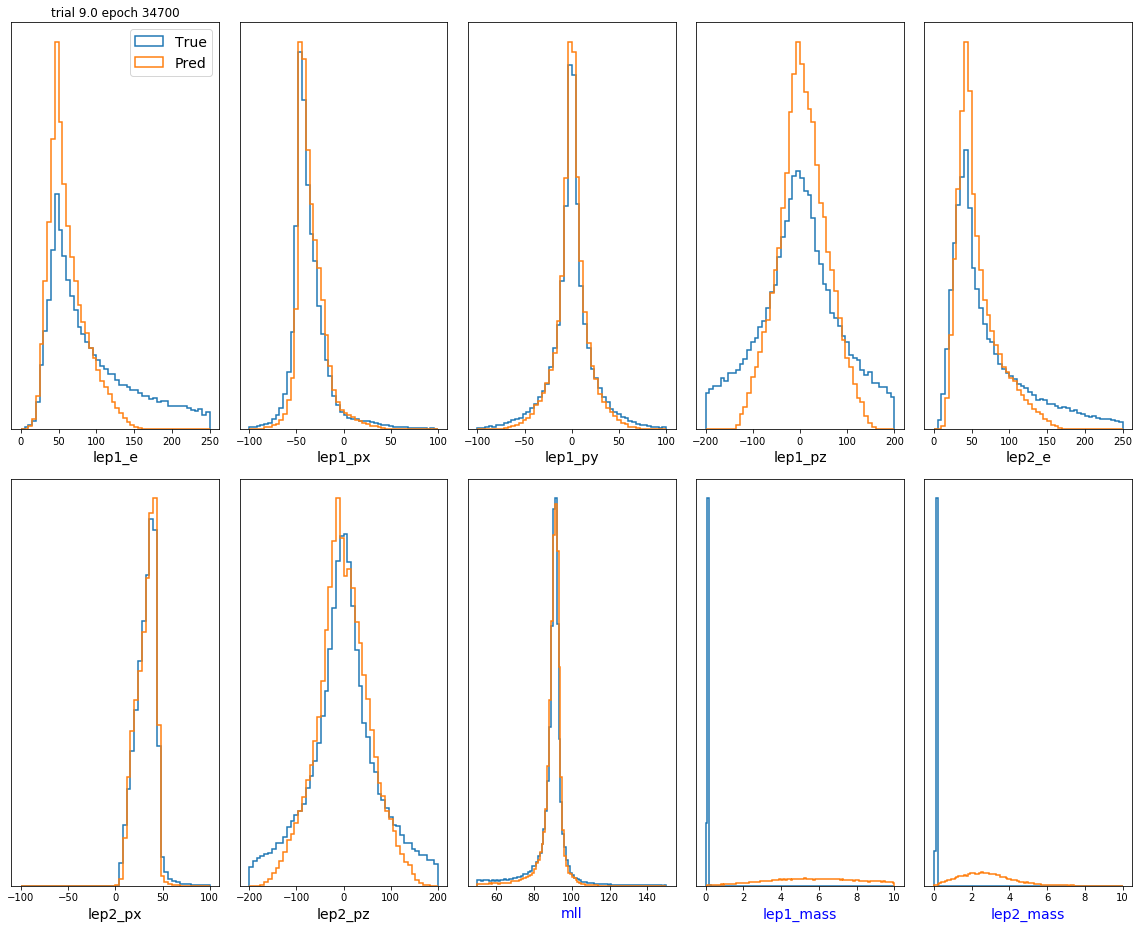

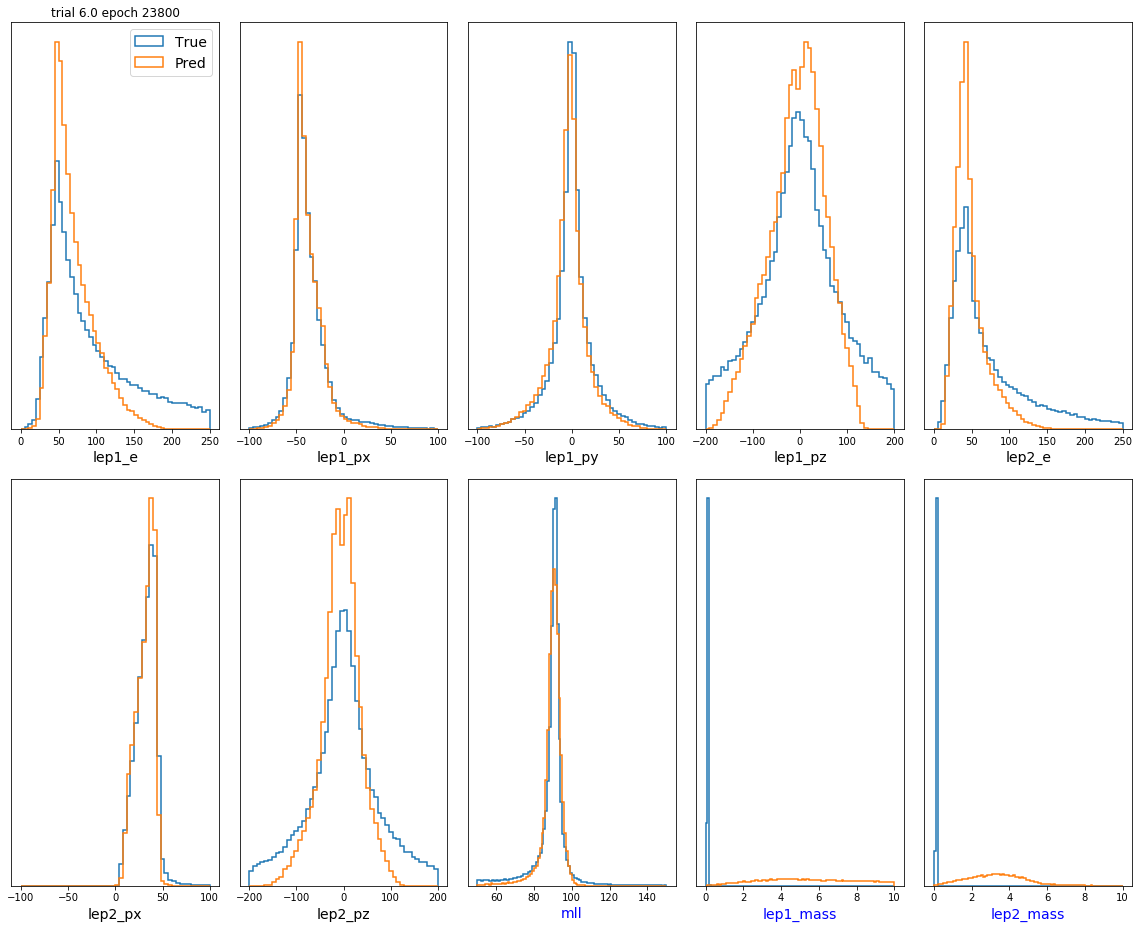

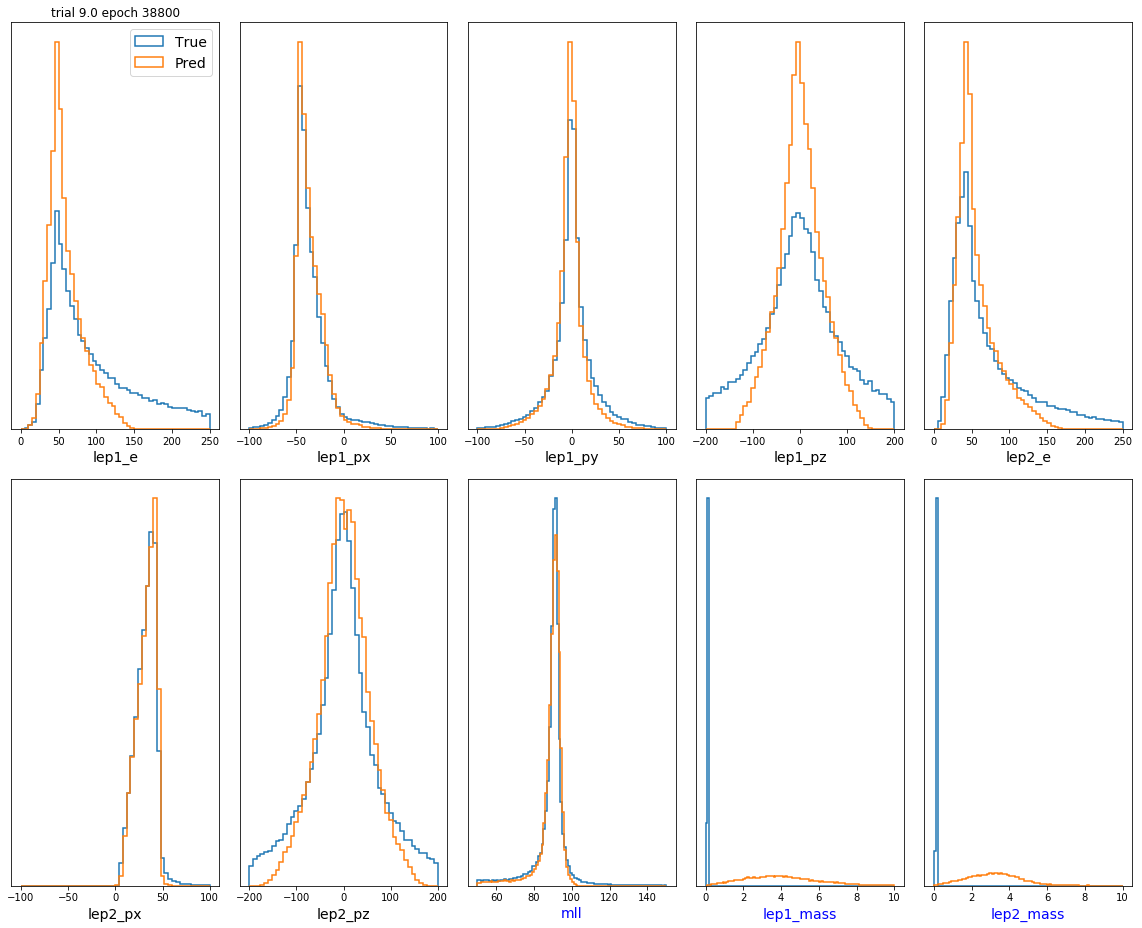

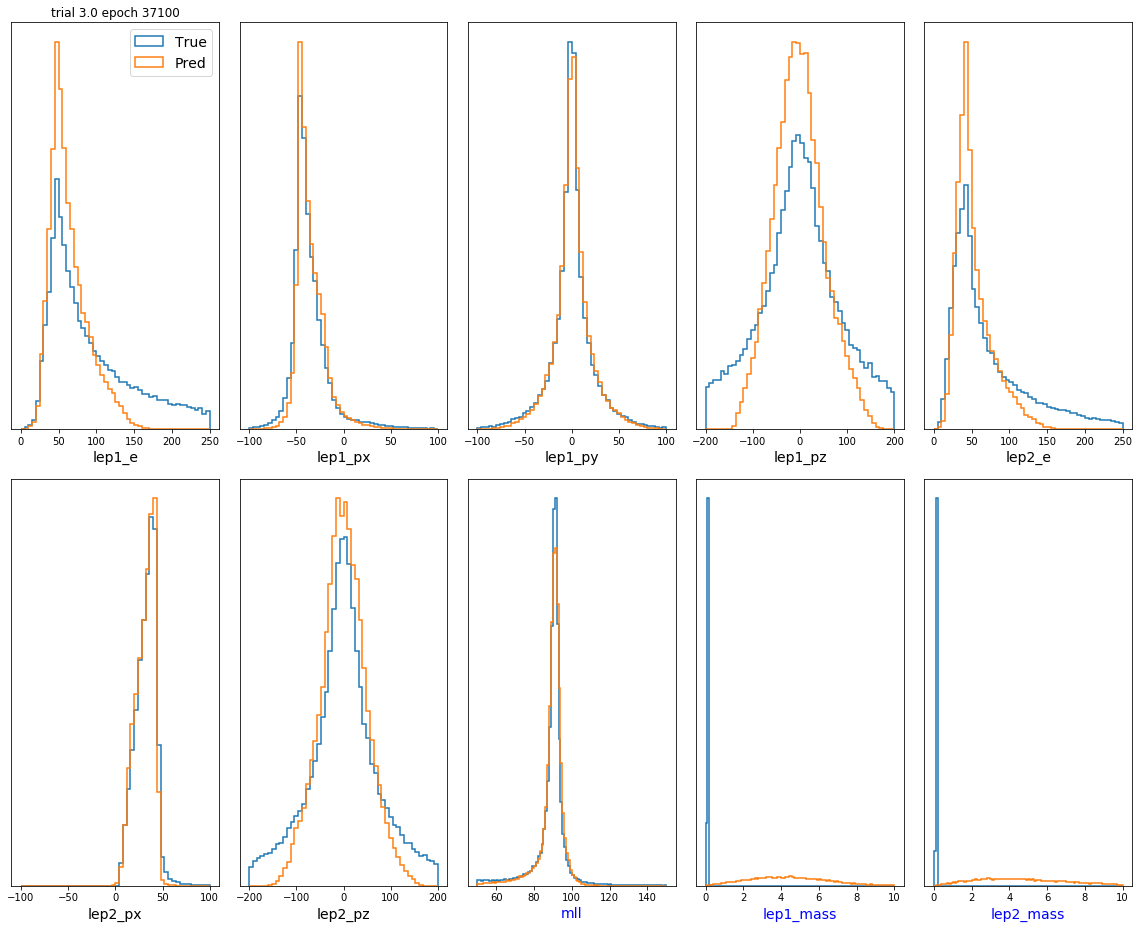

In [71]:
for trial, epoch, score in x[:4]:
    drawResults(target_epoch = epoch, target_trial = trial)

In [ ]:
# gan.tag = "v5_default_scan_0"
gan.load_last_checkpoint()
print "Loaded"

In [ ]:
def smooth(x,window=31,npoly=2):
    from scipy.signal import savgol_filter
    return savgol_filter(x,window,npoly)

fig, (ax1, ax2, ax3,ax4) = plt.subplots(1,4,figsize=(15,3))
# plot losses
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["d_loss"],color="C0",lw=0.5)
ax1.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["g_loss"],color="C1",lw=0.5)
ax1.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["d_loss"]),label="d loss (smoothed)",color="C0")
ax1.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["g_loss"]),label="g loss (smoothed)",color="C1")
ax1.legend()
# plot masses
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_sig"],color="C0",lw=0.5)
ax2.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["mass_mu"],color="C1",lw=0.5)
ax2.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["mass_sig"]),label="Z width (smoothed)",color="C0")
ax2.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["mass_mu"]),label="Z mass (smoothed)",color="C1")
ax2.legend()
# plot ks metrics
ax3.plot(gan.d_epochinfo["epoch"],gan.d_epochinfo["ks"], lw=0.5,color="C0")
ax3.plot(gan.d_epochinfo["epoch"],smooth(gan.d_epochinfo["ks"]), label="KS metric (smooth)",color="C0")
ax3.legend();
# plot times
ax4.plot(gan.d_epochinfo["epoch"],1./60*(np.array(gan.d_epochinfo["time"])-gan.d_epochinfo["time"][0]), label="times [min]")
ax4.legend()

## Plot predictions and real events
Get the noise from the gan object, feed it into the generator, then also take true events (`data`)

In [ ]:
N = 15000
# frac = 0.0001 # 2 events
# frac = 0.00005 # 1 event
frac = 1.0
_, noise = gan.get_noise(N,max_true_samples_frac=frac)
# print preds.shape
preds = gan.generator.predict(noise,verbose=1)
make_plots(preds,gan.data[:N])

## Recarray
The real data (`gan.data`) is a recarray, so column indexing happens with `gan.data["lep1_px"]`.
The predictions from the generator are just normal matrices, so you have to do yucky things like `preds[:,7]`
and keep track of what that means. Use a helper function to get a `np.view` into the predictions so that
they columns can be accessed in the same way.

In [ ]:
def Z_pt(data,haspy2=False):
    pxsum = data["lep1_px"]+data["lep2_px"]
    if haspy2: pysum = data["lep1_py"]+data["lep2_py"]
    else: pysum = data["lep1_py"]
    return np.hypot(pxsum,pysum)

def Z_phi(data,haspy2=False):
    pxsum = data["lep1_px"]+data["lep2_px"]
    if haspy2: pysum = data["lep1_py"]+data["lep2_py"]
    else: pysum = data["lep1_py"]
    return np.arctan2(pysum,pxsum)

def dphiphi(phi1,phi2):
    dphi = phi1-phi2
    dphi[dphi>np.pi] -= 2*np.pi
    dphi[dphi<-np.pi] += 2*np.pi 
    return np.abs(dphi)


def met_phi(data):
    if "met" in data.dtype.names:
        return data["metphi"]
    else:
        return np.arctan2(data["mety"],data["metx"])
    
def met_pt(data):
    if "met" in data.dtype.names:
        return data["met"]
    else:
        return np.hypot(data["metx"],data["mety"])
    
def ht(data):
    return data["jet_pt1"]*(data["jet_pt1"] > 10) + \
           data["jet_pt2"]*(data["jet_pt2"] > 10) + \
           data["jet_pt3"]*(data["jet_pt3"] > 10) + \
           data["jet_pt4"]*(data["jet_pt4"] > 10) + \
           data["jet_pt5"]*(data["jet_pt5"] > 10)

def nvtx(data):
    if "mll" in data.dtype.names:
        return data.nvtxs
    else:
        return np.rint(data["nvtxs"])

In [ ]:
# plot Z_pT for predicted and real events# plot Z 
predsrec = get_recview(preds)
fig,ax = plt.subplots()
ax.hist(Z_pt(gan.data[:10000],haspy2=False), label="Z $p_{T}$ real",bins=np.linspace(0,100,50),histtype="step",density=True,lw=2)
ax.hist(Z_pt(predsrec,haspy2=False),label="Z $p_{T}$ fake",bins=np.linspace(0,100,50),histtype="step",density=True,lw=2)
ax.legend()
ax.set_title("Z-boson $p_T$ for real and fake events");

In [ ]:
fig,ax = plt.subplots()
lowpu_real_met  = met_pt(gan.data)[nvtx(gan.data) < 15]
highpu_real_met = met_pt(gan.data)[nvtx(gan.data) > 25]
lowpu_fake_met  = met_pt(predsrec)[nvtx(predsrec) < 15]
highpu_fake_met = met_pt(predsrec)[nvtx(predsrec) > 25]
bins = np.linspace(0,100,50)
_ = ax.hist(lowpu_real_met,label="low PU, real",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(lowpu_fake_met,label="low PU, fake",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(highpu_real_met,label="high PU, real",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.hist(highpu_fake_met,label="high PU, fake",bins=bins,histtype="step",density=True,lw=1.5)
_ = ax.legend()
# ax.set_yscale("log",nonposy="clip")
_ = ax.set_title("MET for low (nvtx<15) and high (nvtx>25) events")

In [ ]:
from scipy.stats import binned_statistic

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4), sharex=True,sharey=True)

bins = [np.linspace(15,75,15),np.linspace(15,75,15)]

ptj1 = gan.data["jet_pt1"]
zpt = Z_pt(gan.data)
good = (zpt > 15.) & (ptj1 > 15.)
_,_,_,im = ax1.hist2d(ptj1[good],zpt[good],label="real",bins=bins,normed=True) #, norm=LogNorm())
fig.colorbar(im,ax=ax1, format="%.0e")

vals,edges,_ = binned_statistic(ptj1[good],zpt[good],statistic="median",bins=bins[0])
xs = 0.5*(edges[1:] + edges[:-1])
ax1.plot(xs,vals,"ro-",color=(1.0,0.3,0.3),lw=1.,ms=4.5, label="median")
ax1.legend()

ptj1 = predsrec["jet_pt1"]
zpt = Z_pt(predsrec)
good = (zpt > 15.) & (ptj1 > 15.)
_,_,_,im = ax2.hist2d(ptj1[good],zpt[good],label="real",bins=bins,normed=True)
fig.colorbar(im,ax=ax2, format='%.0e')

vals,edges,_ = binned_statistic(ptj1[good],zpt[good],statistic="median",bins=bins[0])
xs = 0.5*(edges[1:] + edges[:-1])
ax2.plot(xs,vals,"ro-",color=(1.0,0.3,0.3),lw=1.,ms=4.5, label="median")
ax2.legend()

ax1.set_title("Real")
ax2.set_title("Fake")
ax1.set_ylabel("Z $p_{T}$")
ax1.set_xlabel("jet 1 $p_{T}$")
ax2.set_xlabel("jet 1 $p_{T}$")


fig.set_tight_layout(True)

In [ ]:
predmll = Minv(preds)
predmll = predmll[np.isfinite(predmll)]
bins = np.linspace(60,120,120)
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True,gridspec_kw={'height_ratios':[9, 2]})
hreal = ax1.hist(gan.data["mll"],bins=bins, label="real $m_{ll}$",histtype="step",density=True,lw=2)
hfake = ax1.hist(predmll,bins=bins, label="fake $m_{ll}$",histtype="step",density=True,lw=2)
ratio = hfake[0]/hreal[0]
ax2.plot(bins[:-1],ratio,marker="o",markersize=3,linewidth=1.5,linestyle="")
ax2.set_ylim([0.5,1.5])
ax2.set_ylabel("fake/real")
_ = ax1.legend()
realmll = gan.data["mll"]
print "real:",realmll.mean(), realmll.std()
print "fake:",predmll.mean(), predmll.std()

In [ ]:
jetmat = np.c_[predsrec["jet_pt1"],predsrec["jet_pt2"],predsrec["jet_pt3"],predsrec["jet_pt4"],predsrec["jet_pt5"]]
# njet counts just any jet with pt>15
njets1 = (jetmat > 15.).sum(axis=-1)
# njet counts only jets with pt>15 starting from first jet if all previous jets pass threshold
# e.g., if jetpt1>15, jetpt2<15, jetpt3>15, then njets==1 in second case, but 2 in first case
njets2 = (jetmat > 15.).argmin(axis=-1)
# turns out the two are very similar


fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3), sharey=False)
for numer,denom,ax in [
    ["jet_pt2","jet_pt1",ax1],
    ["jet_pt3","jet_pt2",ax2],
    ["jet_pt4","jet_pt3",ax3],
]:
    jetratio_real = (gan.data[:N][numer]/gan.data[:N][denom])[(gan.data[:N][denom] > 15.) & (gan.data[:N][numer] > 15.)]
    jetratio_fake = (predsrec[numer]/predsrec[denom])[(predsrec[denom] > 15.) & (predsrec[numer] > 15.)]
    bins = np.linspace(0,4,60)
    ax.hist(jetratio_real,bins=bins,histtype="step",density=True,label="real",lw=1.5)
    ax.hist(jetratio_fake,bins=bins,histtype="step",density=True,label="fake",lw=1.5)
    ax.legend()
    ax.set_title("{} / {} ratio".format(numer,denom))
fig.set_tight_layout(True)

In [ ]:

import glob

picklenames = glob.glob("progress/jetisoscaleRobust_mllwidth_flatNegNoise*/*pkl")
def get_epochks(fname):
    with open(fname) as fh:
        data = pickle.load(fh)
        return np.array(data["epoch"]),np.array(data["ks"])
    return [],[]
#print dirnames
print get_epochks(picklenames[0])
fig,ax = plt.subplots()
for pn in picklenames:
    xs, ys = get_epochks(pn)
#     good = ys < 0.08
#     xs = xs[good]
#     ys = ys[good]
    print pn, xs[ys.argmin()], ys[ys.argmin()]
#     ax.plot(xs,ys, label=pn)
# ax.legend()